In [141]:
# Importing libraries
import pandas as pd
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import Dataset
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import spacy


In [142]:
# Load data
data = pd.read_csv('all_ECB_speeches.csv',sep = '|')

In [143]:
# Remove non-english speeches

# Function to detect language of a given text
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = "Unknown"
    return lang

# Apply the language detection function to each text in your DataFrame
data['language'] = data['contents'].apply(detect_language)

# Filter out the texts that are not in English
data = data[data['language'] == 'en']



In [144]:
# Drop null values
data = data.dropna(subset=['speakers','contents'])
data = data.reset_index(drop=True)

# Remove introduction
for row in range (data.shape[0]):
  speech = re.split(
          " \d+ (January|February|March|April|May|June|July|August|September|October|November|December) \d{4} ",
          data.loc[row, "contents"])
  data.loc[row, "contents"] = speech[-1]

In [145]:
# Split into sentences
sentences_list = []
for row in range (data.shape[0]):
    text = data.loc[row, "contents"]
    sentences = re.split(r'[.!?]', text)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    sentences_list.append(sentences)
data['sentences'] = sentences_list


In [146]:
# Remove stopwords and punctuation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text, re.UNICODE)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

sentences_list = []
for row in range (data.shape[0]):
    sentences = data.loc[row, "sentences"]
    sentences = [preprocess_text(sentence) for sentence in sentences]
    sentences_list.append(sentences)

data['sentences'] = sentences_list


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lavin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lavin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lavin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [147]:
# Vectorize the data
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['sentences'].apply(lambda x: ' '.join(x)))

In [148]:
def get_top_n_words(corpus, n=10):
        vec = CountVectorizer().fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:n]

def KMeans_clustering(X,data,num_clusters):
    new_df = data.copy()
# Determine the number of clusters
    # Execute K-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X)

    # Get cluster labels for each text
    cluster_labels = kmeans.labels_

    # Add cluster labels to the DataFrame
    new_df['cluster'] = cluster_labels

    # Identify the most frequent words in each cluster
    for i in range(num_clusters):
        print(f"Cluster {i}:")
        corpus = new_df[new_df['cluster'] == i]['sentences'].apply(lambda x: ' '.join(x))
        common_words = get_top_n_words(corpus, 10)
        print(common_words,'\n')
    return new_df

    


In [149]:
data_kmeans = KMeans_clustering(X,data,3)


c:\Users\Lavin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
[('bank', 7267), ('euro', 6024), ('payment', 5533), ('european', 4693), ('financial', 4600), ('market', 4599), ('ha', 4530), ('central', 4271), ('also', 4024), ('area', 3791)] 

Cluster 1:
[('policy', 30376), ('euro', 26144), ('monetary', 24519), ('area', 21401), ('rate', 17543), ('inflation', 16900), ('price', 16447), ('ha', 15824), ('economic', 14458), ('market', 14046)] 

Cluster 2:
[('financial', 22665), ('market', 17222), ('bank', 16346), ('risk', 9383), ('policy', 9213), ('euro', 9205), ('ha', 9029), ('area', 8939), ('banking', 6780), ('crisis', 6495)] 



In [150]:
# Cluster 0 seems to be about interest rates
# Cluster 1 seems to be about inflation
# Cluster 2 seems to be about Activity
data_kmeans['cluster'] = data_kmeans['cluster'].replace({0: 'Interest rates', 1: 'Inflation', 2: 'Activity'})

In [151]:
# Classifier using diccionarys
# Dictionary of words related to interest rates
interest_rates_dict = {
    'interest': 1,
    'rate': 1,
    'central bank': 1,
    'monetary policy': 1,
    'European Central Bank': 1,
    'policy rate': 1,
    'benchmark rate': 1,
    'ECB': 1,
    'ECB President': 1,
    'ECB Governing Council': 1,
    'yield curve': 1,
    'nominal rate': 1,
    'real rate': 1,
    'prime rate': 1,
    'discount rate': 1,
    'base rate': 1
}

# Dictionary of words related to inflation
inflation_dict = {
    'inflation': 1,
    'price level': 1,
    'HICP': 1,  # Harmonized Index of Consumer Prices
    'consumer price index': 1,
    'deflation': 1,
    'hyperinflation': 1,
    'core inflation': 1,
    'inflation target': 1,
    'inflation rate': 1,
    'inflationary pressures': 1,
    'cost-push inflation': 1,
    'demand-pull inflation': 1
}

# Dictionary of words related to economic activity (GDP)
economic_activity_dict = {
    'GDP': 1,
    'economic growth': 1,
    'output': 1,
    'economic indicators': 1,
    'business cycle': 1,
    'recession': 1,
    'expansion': 1,
    'unemployment rate': 1,
    'labor market': 1,
    'productivity': 1,
    'investment': 1,
    'consumption': 1,
    'exports': 1,
    'imports': 1,
    'trade balance': 1,
    'eurozone': 1,
    'European Union': 1,
    'euro area': 1,
    'Eurostat': 1,
    'eurozone economy': 1,
    'EU economic policy': 1,
    'EU fiscal policy': 1
}

In [152]:
# Cluster the texts based on the dictionaries
def classify_text(text):
    scores = [0, 0, 0]
    for sentence in text:
        interest_rates_score = sum([interest_rates_dict.get(word, 0) for word in sentence.split()])
        inflation_score = sum([inflation_dict.get(word, 0) for word in sentence.split()])
        economic_activity_score = sum([economic_activity_dict.get(word, 0) for word in sentence.split()])
        scores[0] += interest_rates_score
        scores[1] += inflation_score
        scores[2] += economic_activity_score
    if sum(scores) == 0:
        return scores, -1
    return scores, np.argmax(scores)

def Dictionary_clustering(data):
    new_df = data.copy()
    new_df['scores'] = new_df['sentences'].apply(lambda x: classify_text(x)[0])
    new_df['cluster'] = new_df['sentences'].apply(lambda x: classify_text(x)[1])

    for i in range(3):
        print(f"Cluster {i}:")
        corpus = new_df[new_df['cluster'] == i]['sentences'].apply(lambda x: ' '.join(x))
        common_words = get_top_n_words(corpus, 10)
        print(common_words,'\n')
    return new_df


In [153]:
data_dict = Dictionary_clustering(data)

Cluster 0:
[('policy', 27508), ('euro', 26830), ('bank', 24109), ('financial', 23747), ('market', 23598), ('monetary', 21580), ('area', 20798), ('ha', 18110), ('rate', 17839), ('central', 12778)] 

Cluster 1:
[('inflation', 10737), ('policy', 9994), ('monetary', 8559), ('price', 7162), ('euro', 6832), ('area', 6262), ('ha', 5111), ('bank', 4862), ('economic', 4463), ('financial', 3893)] 

Cluster 2:
[('financial', 8855), ('market', 7314), ('euro', 6580), ('area', 6422), ('bank', 5652), ('ha', 5259), ('policy', 5123), ('risk', 4503), ('growth', 4377), ('european', 4005)] 



In [154]:
# Replace cluster labels with corresponding categories
data_dict['cluster'] = data_dict['cluster'].replace({0: 'Interest rates', 1: 'Inflation', 2: 'Activity', -1: 'Unknown'})



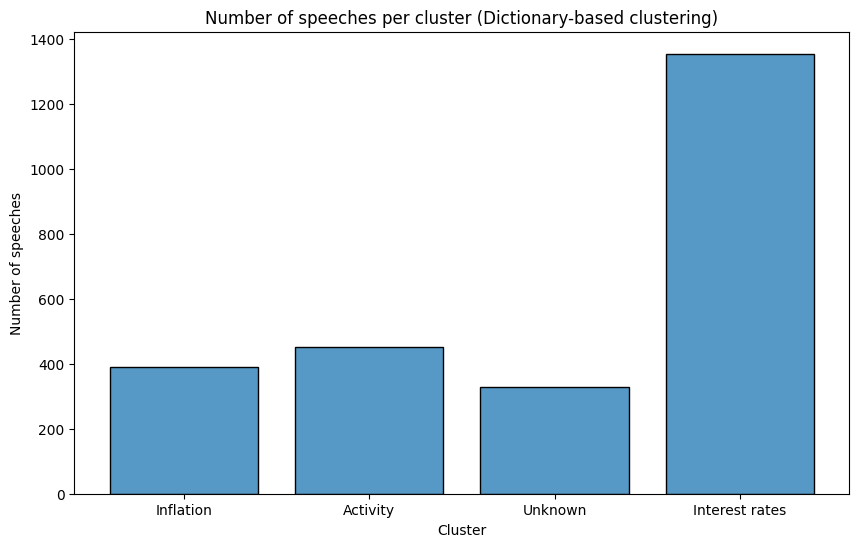

In [155]:
# Histogram of the clusters
plt.figure(figsize=(10, 6))
sns.histplot(data_dict['cluster'], discrete=True, shrink=0.8)
plt.title('Number of speeches per cluster (Dictionary-based clustering)')
plt.xlabel('Cluster')
plt.ylabel('Number of speeches')
plt.show()


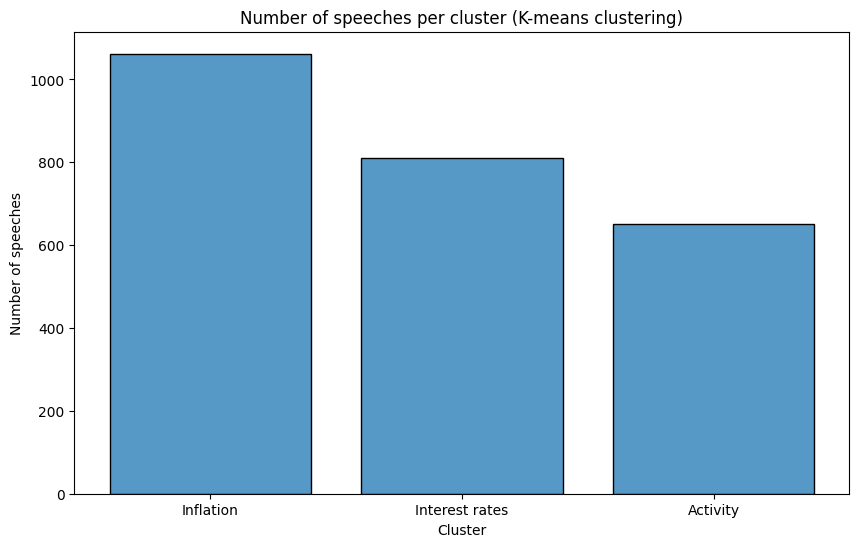

In [156]:
# Histogram of the clusters
plt.figure(figsize=(10, 6))
sns.histplot(data_kmeans['cluster'], discrete=True, shrink=0.8)
plt.title('Number of speeches per cluster (K-means clustering)')
plt.xlabel('Cluster')
plt.ylabel('Number of speeches')
plt.show()


In [157]:
# Amount of speeches classified differently by the two methods
# Plot in a confusion matrix